In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))

In [125]:
import pandas as pd
import numpy as np
from statsmodels.graphics import tsaplots
from statsmodels.stats import diagnostic
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import scipy

from dataset import Dataset
import plotting

In [6]:
dataset = Dataset('../data/dataset/')

In [8]:
# Возьмем временной ряд.

In [9]:
ts = dataset['international-airline-passengers.csv']

In [10]:
# нарисуем. Видим ярко выраженную сезонность (мб не одну?), гетероскедастичность и тренд.

<Axes: xlabel='1949-01'>

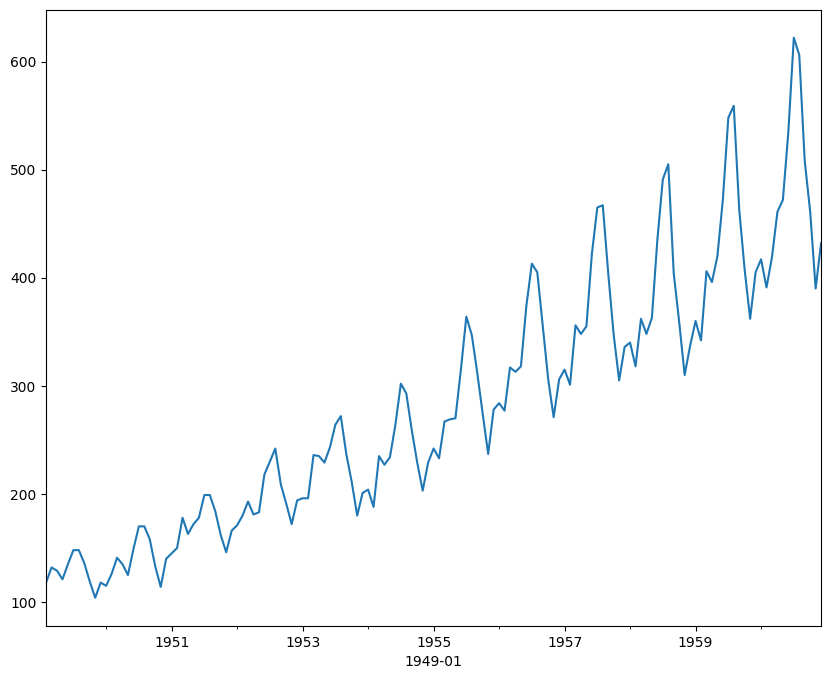

In [11]:
ts.plot(figsize=(10, 8))

In [12]:
# Посммотрим график автокорреляций - видим тренд и сильную цикличную автокореляцию

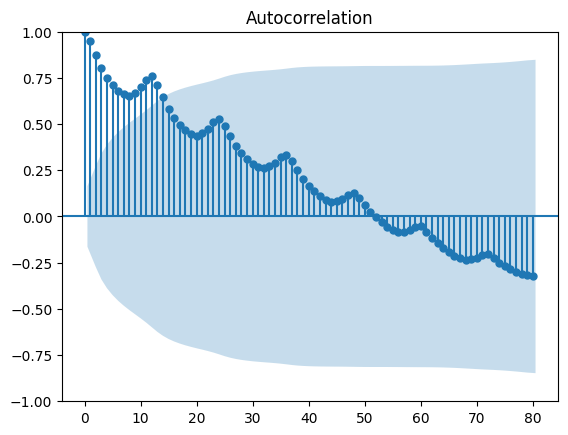

In [13]:
tsaplots.plot_acf(ts, lags=80);

In [14]:
# проверим автокорреляция при помощи теса Ланга-Бокса

In [15]:
res = diagnostic.acorr_ljungbox(ts)

In [16]:
p_value = res['lb_pvalue']

In [17]:
# видим, что значения p-value сильно ниже порога (обычно 0.05, 0.01), значит мы смело отвергаем нулевую гипотезу
# то есть данные явно не случайны
max(p_value), min(p_value)

(2.2652961479648238e-30, 1.4807047715349232e-175)

In [18]:
# проверим ряд на стационарость критерием Дики-Фуллера
# видим, что p-value сильно выше порога, значит мы никак не можем отвергнуть нулевую гипотезу, следовательно -
# ряд не стационарен
p_value = adfuller(ts)[1]
p_value

0.9915115096288659

In [19]:
# Попробуем сделать его стационарным
# Для начала постараемся избавиться от гетероскедастичности, взяв логарифм
ts_log = np.log(ts)

<Axes: xlabel='1949-01'>

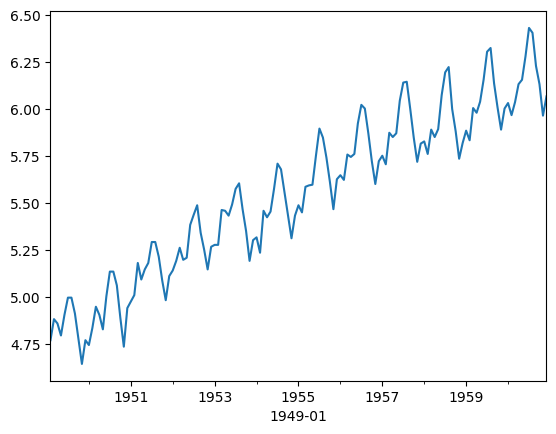

In [20]:
ts_log.plot()
# отлично, на вид, гетероскедастичность ушла

In [21]:
# впрочем, наши статистические тесты остались этим неудовлетворены и снова показывают крайнюю нестационарность
# скоррелированность
res = diagnostic.acorr_ljungbox(ts_log)
p_value = res['lb_pvalue']
print(min(p_value), max(p_value))
print(adfuller(ts)[1])

4.552029430390749e-201 9.436327894354164e-31
0.9915115096288659


In [22]:
# чтож, попробуем применить дифференцирование
ts_diff = ts_log.diff()

In [23]:
plotting.plot_ts(ts_log, ts_diff)

Loading BokehJS ...

In [24]:
res = diagnostic.acorr_ljungbox(ts_diff.dropna(), lags=70)
p_value = res['lb_pvalue']

print(min(p_value), max(p_value))
print(adfuller(ts_diff.dropna())[1])

4.0377134029615935e-107 0.021048164264366412
0.048033972528750794


<Axes: xlabel='1949-01'>

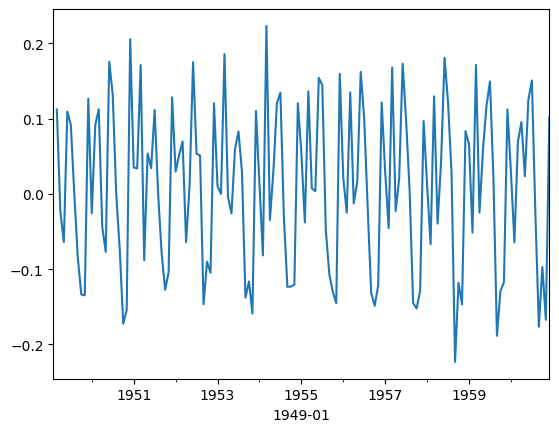

In [25]:
ts_diff.plot()

In [26]:
# кхмм, опять не помогает, давайте посмотрим на график автокорреляций и увидим, что период сезонности 
# приходится на 12 лаг, попробуем сезонное дифференцирование

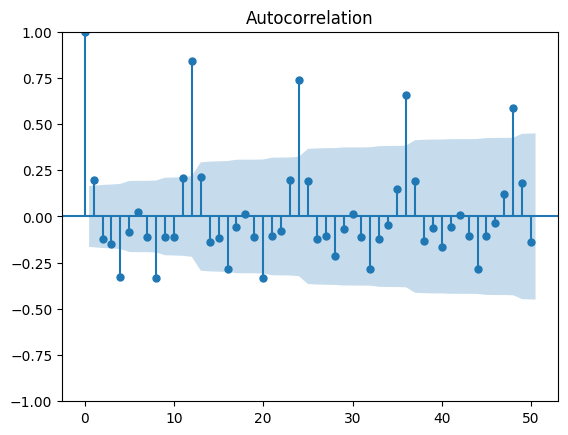

In [27]:
tsaplots.plot_acf(ts_diff.dropna(), lags=50);

In [28]:
ts_season_diff = ts_diff.diff(12)

In [29]:
res = diagnostic.acorr_ljungbox(ts_season_diff.dropna(), lags=45)

p_value = res['lb_pvalue']
print(min(p_value), max(p_value))
print(adfuller(ts_season_diff.dropna())[1])

6.188062493682556e-07 0.0025904863525081606
0.00016009049261960472


<Axes: xlabel='1949-01'>

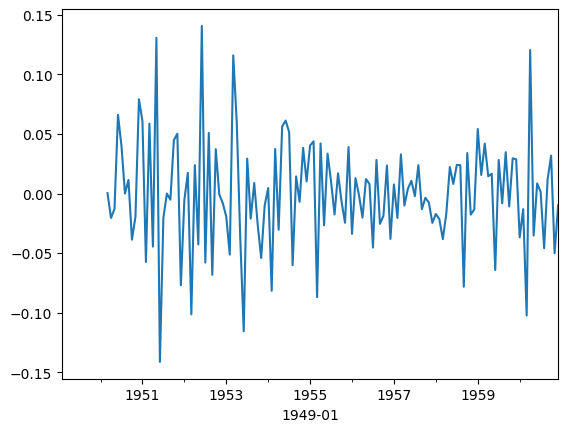

In [30]:
ts_season_diff.plot()

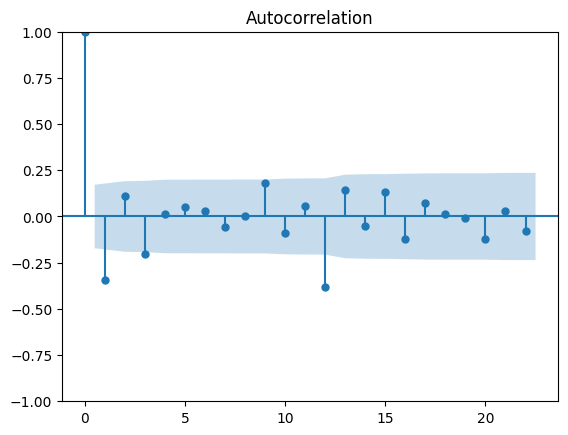

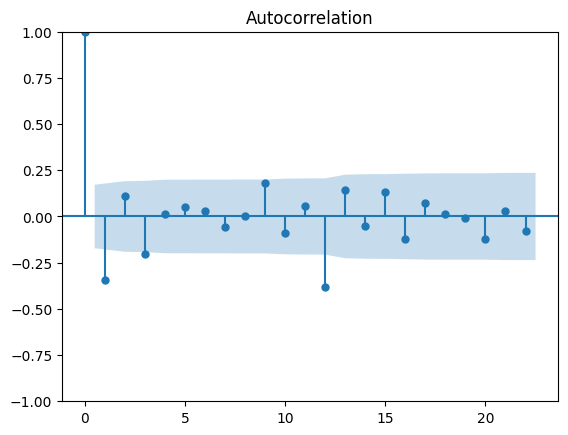

In [31]:
tsaplots.plot_acf(ts_season_diff.dropna())

In [32]:
# Бонус - пример простого обратно трансформирования ряда. По сути, к ряду просто применяются обратные операторы.
# exp для log, кумулятивная сумма для дифференцирования

In [33]:
ts = dataset['hour_3553.csv']

<Axes: xlabel='2019-05-19T03:00:00'>

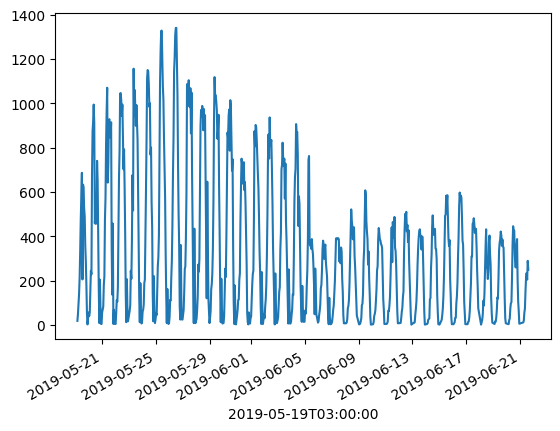

In [34]:
ts.plot()

In [35]:
transformed = np.log(ts).diff()

<Axes: xlabel='2019-05-19T03:00:00'>

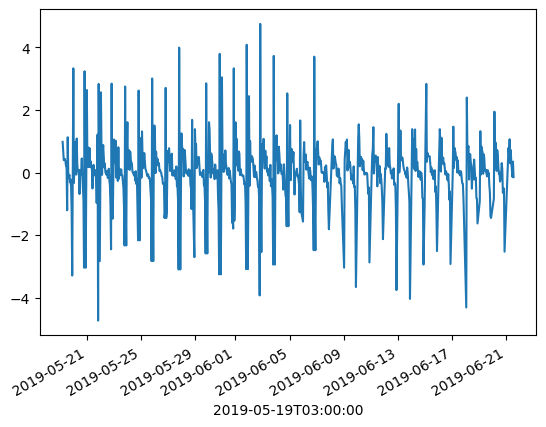

In [36]:
transformed.plot()

In [37]:
back_transformed = np.exp(transformed.cumsum())

<Axes: xlabel='2019-05-19T03:00:00'>

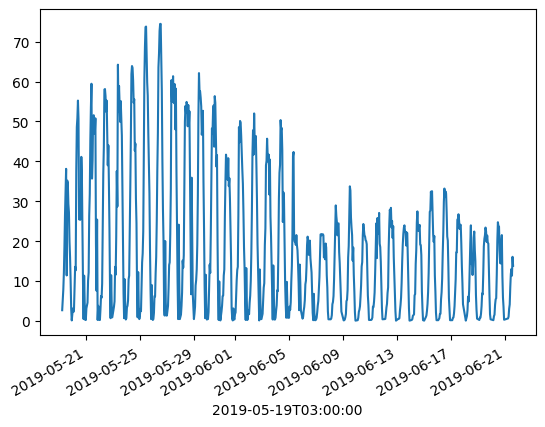

In [38]:
back_transformed.plot()

## Задание:
    1. Выбрать ряд seasonal_stl.csv.
    2. Используя вышеперечисленные преобразования, добиться стационарности ряда.
    3. Критерием стационарности будет служить значение p-value теста Дики-Фуллера, меньшее 0.05 и соответствующий график.

In [131]:
ts = dataset['seasonal_stl.csv']